## Imports

In [43]:

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score, r2_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Tuple, List, Dict


## Baisc links

In [16]:

CSV_PATH = "/Users/chielarkink/Downloads/default of credit card clients.csv"
TARGET_COL = "default_payment_next_month"
TEST_SIZE = 0.5
RANDOM_STATE = 42
MIN_PRECISION = 0.5


## Data cleaning data
- Verwijder indexkolommen zoals Unnamed: 0 of ID indien aanwezig.
- Controleer op volledig lege kolommen.

In [19]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    for col in ["Unnamed: 0", "ID"]:
        if col in df.columns:
            df = df.drop(columns=[col])
    empty_cols = [c for c in df.columns if df[c].isna().all()]
    if empty_cols:
        df = df.drop(columns=empty_cols)
    return df

df = pd.read_csv(CSV_PATH, sep=';')
df = clean_dataframe(df)

print("Vorm na opschonen:", df.shape)
print("Eerste kolommen:", list(df.columns)[:10], "...")
assert TARGET_COL in df.columns, f"Target kolom '{TARGET_COL}' niet gevonden."

Vorm na opschonen: (30000, 24)
Eerste kolommen: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'] ...


## Train/Test-split (50/50)
Opsplitsen van de data

In [20]:

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (15000, 23) Test shape: (15000, 23)


## categorisch vs numeriek
data labels toepassen

In [21]:

def get_feature_splits(df: pd.DataFrame, target_col: str) -> Tuple[List[str], List[str]]:
    categorical_candidates = ["SEX", "EDUCATION", "MARRIAGE"] + [f"PAY_{i}" for i in range(0, 7)]
    categorical_cols = [c for c in categorical_candidates if c in df.columns and c != target_col]
    numeric_cols = [c for c in df.columns if c not in categorical_cols + [target_col]]
    return categorical_cols, numeric_cols

categorical_cols, numeric_cols = get_feature_splits(df, TARGET_COL)
categorical_cols, numeric_cols


(['SEX',
  'EDUCATION',
  'MARRIAGE',
  'PAY_0',
  'PAY_2',
  'PAY_3',
  'PAY_4',
  'PAY_5',
  'PAY_6'],
 ['LIMIT_BAL',
  'AGE',
  'BILL_AMT1',
  'BILL_AMT2',
  'BILL_AMT3',
  'BILL_AMT4',
  'BILL_AMT5',
  'BILL_AMT6',
  'PAY_AMT1',
  'PAY_AMT2',
  'PAY_AMT3',
  'PAY_AMT4',
  'PAY_AMT5',
  'PAY_AMT6'])

## Preprocessing pipeline
- `OneHotEncoder` voor categorische kolommen
- `StandardScaler` voor numerieke kolommen

In [22]:

def build_preprocessor(categorical_cols: List[str], numeric_cols: List[str]) -> ColumnTransformer:
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
            ("num", StandardScaler(), numeric_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    return preprocessor

preprocessor = build_preprocessor(categorical_cols, numeric_cols)
preprocessor


,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


## Modellen in Pipelines
We maken drie modellen: Logistic Regression, Random Forest en KNN(100).

In [23]:

@dataclass
class ModelSpec:
    name: str
    pipeline: Pipeline

def make_model_specs(preprocessor: ColumnTransformer):
    specs = []

    log_reg = Pipeline([("prep", preprocessor),
                        ("clf", LogisticRegression(max_iter=1000))])

    rf = Pipeline([("prep", preprocessor),
                   ("clf", RandomForestClassifier(random_state=42))])

    knn100 = Pipeline([("prep", preprocessor),
                       ("clf", KNeighborsClassifier(n_neighbors=100))])

    specs.extend([
        ModelSpec("LogisticRegression", log_reg),
        ModelSpec("RandomForest", rf),
        ModelSpec("KNN_100", knn100)
    ])
    return specs

specs = make_model_specs(preprocessor)
[x.name for x in specs]


['LogisticRegression', 'RandomForest', 'KNN_100']

## Cross-validation
predict_proba methode op de trainingsset toepassen

In [24]:

cv_probas = {}
for spec in specs:
    print(f"[CV] {spec.name} – predict_proba (5-fold)")
    proba_train = cross_val_predict(
        estimator=spec.pipeline,
        X=X_train,
        y=y_train,
        cv=5,
        method="predict_proba",
        n_jobs=-1
    )
    cv_probas[spec.name] = proba_train[:, 1]  # kans op klasse 1
print("Klaar.")


[CV] LogisticRegression – predict_proba (5-fold)
[CV] RandomForest – predict_proba (5-fold)
[CV] KNN_100 – predict_proba (5-fold)
Klaar.


## Threshold zoeken bij `precision ≥ 0.5`
We lopen thresholds van 0.0 tot 1.0 af en kiezen de **hoogste recall** die nog aan de precision-eis voldoet.

In [25]:

def find_best_threshold(y_true: np.ndarray, y_proba: np.ndarray, min_precision: float = 0.5):
    thresholds = np.linspace(0.0, 1.0, num=1001)
    best_t, best_prec, best_rec = 0.5, 0.0, 0.0
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        if prec >= min_precision and rec > best_rec:
            best_t, best_prec, best_rec = t, prec, rec
    # Fallback: als niets voldoet, rapporteer metrics bij t=0.5
    if best_rec == 0.0 and best_prec < min_precision:
        t = 0.5
        y_pred = (y_proba >= t).astype(int)
        best_prec = precision_score(y_true, y_pred, zero_division=0)
        best_rec = recall_score(y_true, y_pred, zero_division=0)
        best_t = t
    return best_t, best_prec, best_rec

cv_rows = []
for name, p_train in cv_probas.items():
    t, p, r = find_best_threshold(y_train, p_train, min_precision=MIN_PRECISION)
    cv_rows.append({"model": name, "best_threshold": t,
                    "cv_precision_at_t": p, "cv_recall_at_t": r})

cv_table = pd.DataFrame(cv_rows).sort_values("cv_recall_at_t", ascending=False)
cv_table


,model,best_threshold,cv_precision_at_t,cv_recall_at_t
0,LogisticRegression,0.228,0.500800,0.566004
1,RandomForest,0.301,0.503629,0.543701
2,KNN_100,0.231,0.517880,0.488849


In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_pr_curves(specs, X_test, y_test):
    plt.figure()
    for s in specs:
        proba = s.pipeline.predict_proba(X_test)[:, 1]
        p, r, _ = precision_recall_curve(y_test, proba)
        ap = average_precision_score(y_test, proba)
        plt.plot(r, p, label=f"{s.name} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (test)")
    plt.legend(); plt.show()

In [30]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration(specs, X_test, y_test, n_bins=10):
    plt.figure()
    for s in specs:
        p = s.pipeline.predict_proba(X_test)[:, 1]
        frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=n_bins, strategy="uniform")
        plt.plot(mean_pred, frac_pos, marker="o", label=s.name)
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("Gemiddelde voorspelde p"); plt.ylabel("Werkelijk default-aandeel")
    plt.title("Calibration curve (test)"); plt.legend(); plt.show()

## Retrainen of complete trainingsset & testen on testset
We trainen de modellen opnieuw op de hele trainingsset en evalueren op de testset met de thresholds die uit cross-validation kwamen.

In [26]:

def evaluate_on_test(y_true: np.ndarray, y_proba: np.ndarray, threshold: float) -> Dict[str, float]:
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_true, y_pred)
    }

name_to_spec = {s.name: s for s in specs}
test_rows = []
for _, row in cv_table.iterrows():
    name = row["model"]
    t = float(row["best_threshold"])
    spec = name_to_spec[name]
    # fit op trainingsset
    spec.pipeline.fit(X_train, y_train)
    # kansen op testset
    p_test = spec.pipeline.predict_proba(X_test)[:, 1]
    scores = evaluate_on_test(y_test, p_test, threshold=t)
    test_rows.append({
        "model": name,
        "threshold_from_cv": t,
        "test_precision": scores["precision"],
        "test_recall": scores["recall"],
        "test_accuracy": scores["accuracy"]
    })

test_table = pd.DataFrame(test_rows).sort_values("test_recall", ascending=False)
test_table


,model,threshold_from_cv,test_precision,test_recall,test_accuracy
0,LogisticRegression,0.228,0.499597,0.560880,0.778600
1,RandomForest,0.301,0.505313,0.544605,0.781333
2,KNN_100,0.231,0.507597,0.493369,0.782067


## Visualise ROC curve

In [44]:
def lift_chart(y_true, p_model):
    """Bereken de lift-curves en area ratio (zoals in de paper)."""
    asort = np.argsort(p_model)
    y_sorted = y_true[asort]
    positive_instances = np.sum(y_true)
    total_instances = len(y_true)
    positive_rate = positive_instances / total_instances

    model_values = []
    naive_model_values = []
    ideal_model_values = []

    for i in range(1, total_instances):
        model_values.append(np.sum(y_sorted[:i]))
        naive_model_values.append(np.round(positive_rate * i))
        ideal_model_values.append(min(i, positive_instances))

    model_values = np.array(model_values)
    naive_model_values = np.array(naive_model_values)
    ideal_model_values = np.array(ideal_model_values)

    lift_area = np.sum(model_values - naive_model_values)
    ideal_area = np.sum(ideal_model_values - naive_model_values)

    area_ratio = lift_area / ideal_area if ideal_area != 0 else np.nan

    return model_values, naive_model_values, ideal_model_values, area_ratio


def plot_lift(specs, X_test, y_test):
    """Plot de lift-curves voor alle modellen en toon de area ratios."""
    plt.figure(figsize=(7, 5))
    ratios = {}

    for s in specs:
        p = s.pipeline.predict_proba(X_test)[:, 1]
        model_values, naive, ideal, ratio = lift_chart(y_test, p)
        plt.plot(model_values, label=f"{s.name} (area ratio={ratio:.2f})")
        ratios[s.name] = ratio

    plt.xlabel("Aantal observaties (gesorteerd op kans)")
    plt.ylabel("Cumulatief aantal defaults")
    plt.title("Lift chart (testset)")
    plt.legend()
    plt.show()

    return ratios

def ssm_scatter(y_true, p, window=50):
    """
    SSM (Sorting Smoothing Method) plot zoals in de paper.
    - Sorteert observaties op voorspelde kans.
    - Smooth de werkelijke defaults met een moving average.
    - Past een lineaire regressie toe: Y = A + B * X.
    """
    order = np.argsort(p)
    y_sorted = y_true[order]
    p_sorted = p[order]

    # moving average over 2n+1 (zoals beschreven in de paper)
    n = window
    y_pad = np.pad(y_sorted, (n, n), mode="edge")
    smooth = np.convolve(y_pad, np.ones(2*n+1)/(2*n+1), mode="valid")

    # lineaire fit
    reg = LinearRegression().fit(p_sorted.reshape(-1, 1), smooth)
    yhat = reg.predict(p_sorted.reshape(-1, 1))
    r2 = r2_score(smooth, yhat)

    plt.figure(figsize=(6, 5))
    plt.scatter(p_sorted, smooth, s=4, label="Smoothed actual")
    plt.plot(p_sorted, yhat, color="red", label=f"Fit (A={reg.intercept_:.3f}, B={reg.coef_[0]:.3f})")
    plt.xlabel("Predicted probability")
    plt.ylabel("Smoothed actual default probability")
    plt.title(f"SSM scatter – R²={r2:.3f}")
    plt.legend()
    plt.show()

    return {"A": reg.intercept_, "B": reg.coef_[0], "R2": r2}

,model,best_threshold,cv_precision_at_t,cv_recall_at_t
0,LogisticRegression,0.228,0.500800,0.566004
1,RandomForest,0.301,0.503629,0.543701
2,KNN_100,0.231,0.517880,0.488849


,model,threshold_from_cv,test_precision,test_recall,test_accuracy
0,LogisticRegression,0.228,0.499597,0.560880,0.778600
1,RandomForest,0.301,0.505313,0.544605,0.781333
2,KNN_100,0.231,0.507597,0.493369,0.782067


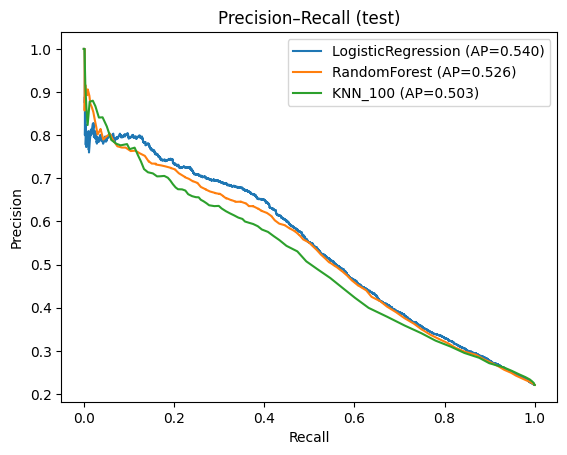

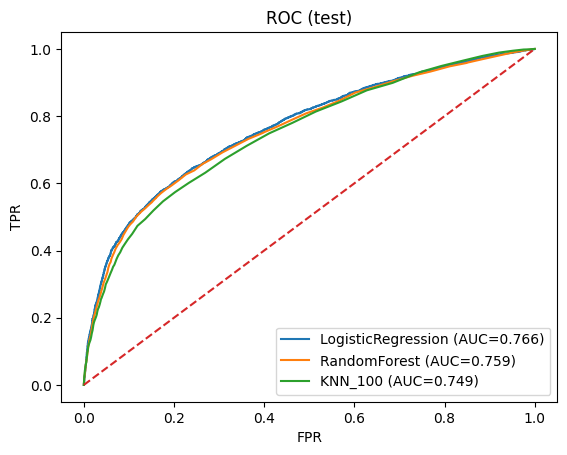

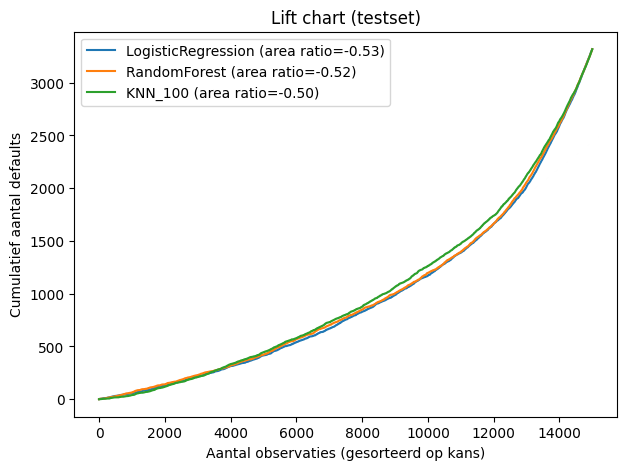

Area ratios per model:
LogisticRegression   -0.531
RandomForest         -0.519
KNN_100              -0.499
dtype: float64


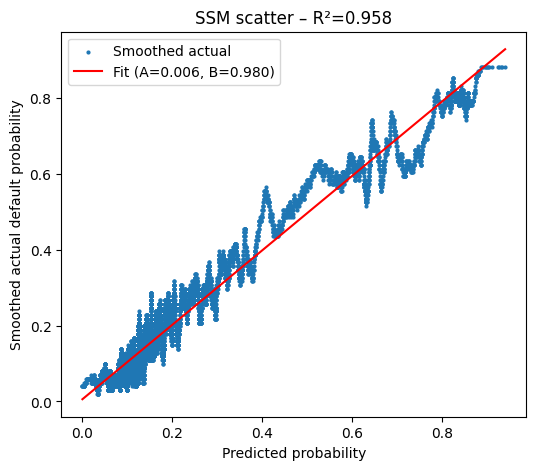

SSM-statistieken (LogisticRegression): {'A': 0.00598816786888709, 'B': 0.9801213602981775, 'R2': 0.9579348047875408}


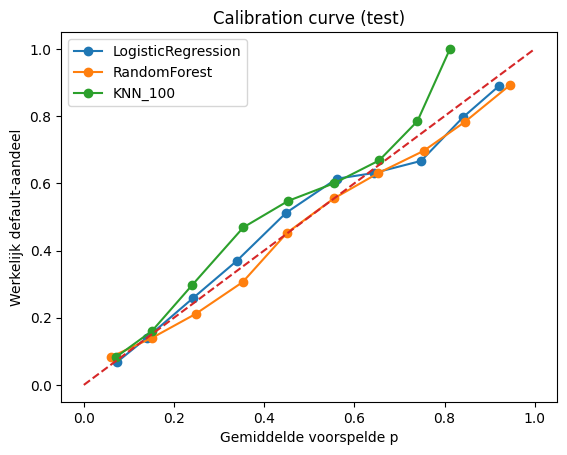

In [45]:
for s in specs:
    if not hasattr(s.pipeline, "classes_"):
        s.pipeline.fit(X_train, y_train)

# Toon de tabellen duidelijk
from IPython.display import display
display(cv_table)
display(test_table)

# PR-curve(s)
plot_pr_curves(specs, X_test, y_test)

# ROC-curve(s)
plot_roc(specs, X_test, y_test)

# Lift chart(s) + area ratio
ratios = plot_lift(specs, X_test, y_test)
print("Area ratios per model:")
print(pd.Series(ratios).round(3))

# (optioneel) SSM-scatter voor 1 model (bijv. Logistic Regression)
log_proba = [s for s in specs if s.name == "LogisticRegression"][0].pipeline.predict_proba(X_test)[:, 1]
ssm_stats = ssm_scatter(y_test, log_proba, window=50)
print("SSM-statistieken (LogisticRegression):", ssm_stats)

# Calibration curve(s)
plot_calibration(specs, X_test, y_test, n_bins=10)

## Summary
Welk model behaalt de hoogste **recall** op de testset (gegeven dat precision ≥ 0.5 in CV)?

In [27]:

best_model = test_table.iloc[0]["model"]
print(f"Beste recall (test) bij threshold uit CV: {best_model}")
display(cv_table)
display(test_table)


Beste recall (test) bij threshold uit CV: LogisticRegression


,model,best_threshold,cv_precision_at_t,cv_recall_at_t
0,LogisticRegression,0.228,0.500800,0.566004
1,RandomForest,0.301,0.503629,0.543701
2,KNN_100,0.231,0.517880,0.488849


,model,threshold_from_cv,test_precision,test_recall,test_accuracy
0,LogisticRegression,0.228,0.499597,0.560880,0.778600
1,RandomForest,0.301,0.505313,0.544605,0.781333
2,KNN_100,0.231,0.507597,0.493369,0.782067
